# Amplicon sequencing use case
with 3 infant gut development studies, namely:

| Bioproject ID | Publication DOI | Publication Title |
| :----------- | :----------- | :----------- |
| PRJEB16321 | 10.1038/srep40932 | The Fecal Microbial Community of Breast-fed Infants from Armenia and Georgia |
| PRJEB15633 | 10.1038/srep40466 | Growth and Morbidity of Gambian Infants are Influenced by Maternal Milk Oligosaccharides and Infant Gut Microbiota |
| PRJEB23239 | 10.1093/ajcn/nqy249  | Anemia in infancy is associated with alterations in systemic metabolism and microbial structure and function in a sex-specific manner: an observational study |

All 3 studies sequenced 16S rRNA Genes in V4 region (see values in `df_meta` columns `'Target Gene [experiment]'` & `'Target Subfragment [experiment]'`). 


**This is merely a demonstration of what sort of analysis could be performed with data fetched using q2-fondue. It does not control for study covariates and should not be replicated directly in a proper meta-analysis.**

In [1]:
# import required packages
import os
import biom
import pandas as pd
import numpy as np
import qiime2 as q2
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from qiime2.plugins import (fondue,
                            metadata,
                            coordinates,
                            demux, dada2,
                            diversity,
                            sample_classifier as sc,
                            feature_table as ft)
from q2_sample_classifier.visuals import _generate_roc_plots

mpl.rcParams['figure.dpi'] = 300

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
# USER-DEFINED variables

# where to store results of amplicon usecase data
results_path = "u1-amplicon-results"
# your email
email = "my@mail.com"
# number of jobs for running q2fondue's get-all
n_jobs = 8


In [3]:
def def_age_group(x):
    """
    Categorize numeric age in `x` into groups of defined 
    age month ranges.
    """
    if x < 1:
        age_group = '0-1 mo'
    elif x <= 4:
        age_group = '1-4 mo'
    elif x <= 6:
        age_group = '4-6 mo'
    else:
        age_group = '6+ mo'
    return age_group


In [4]:
# create missing folders
if not os.path.exists(results_path):
    os.makedirs(results_path)

# define paths derived from results_path
meta_path = os.path.join(results_path, "metadata.qza")
seq_path = os.path.join(results_path, "single_reads.qza")


## Get metadata and sequences

First we will get all the metadata and sequence data of the studies:

In [5]:
# define accession IDs to get:
ls_ids = ['PRJEB16321', 'PRJEB15633', 'PRJEB23239']
ser_ids = pd.DataFrame({'id': ls_ids}).squeeze()
artifact_ids = q2.Artifact.import_data('NCBIAccessionIDs', ser_ids)

# ! first time get_all takes approx. 30 min to complete (with n_jobs = 7)
if not os.path.isfile(meta_path) and not os.path.isfile(seq_path):
    # fetch metadata and sequences
    meta_md, single_reads, _, failed_ids, = fondue.actions.get_all(
        accession_ids=artifact_ids,
        email=email,
        n_jobs=n_jobs,
        log_level="WARNING"
    )

    # refetch once if needed
    if failed_ids.view(pd.DataFrame).shape[0] > 0:
        print('Refetching failed ids')
        meta_md_r1, single_reads_r1, _, failed_ids_r1, = fondue.actions.get_all(
            accession_ids=failed_ids,
            email=email,
            n_jobs=n_jobs,
            log_level="WARNING"
        )
        # merge outputs
        meta_md = meta_md.merge_metadata(meta_md_r1)
        single_reads = single_reads.combine_seqs(single_reads_r1)

    # save for future reuse
    meta_md.save(meta_path)
    single_reads.save(seq_path)
else:
    meta_md = q2.Artifact.load(meta_path)
    single_reads = q2.Artifact.load(seq_path)


2022-07-18 10:30:27,652 [MainThread] [INFO] [q2_fondue.sequences]: Downloading sequences for 350 accession IDs...


2022-07-18 11:26:23,402 [MainThread] [INFO] [q2_fondue.sequences]: Download finished.
2022-07-18 11:26:32,371 [MainThread] [WARNING] [q2_fondue.sequences]: No paired-read sequences available for these accession IDs.


/Users/anjaadamov/opt/anaconda3/envs/fondue-pub/lib/python3.8/site-packages/q2_fondue/sequences.py:228: UserWarning: No paired-read sequences available for these accession IDs.
  warn(warn_msg)


Let's have a look at the obtained raw metadata with the `qiime metadata tabulate` method:

In [6]:
meta_view = metadata.visualizers.tabulate(meta_md.view(q2.Metadata))
meta_view.visualization


<visualization: Visualization uuid: 6a7163f5-293c-43cc-8110-01d4e7a5e3c3>

In [7]:
# transform meta_md to df
df_meta = meta_md.view(pd.DataFrame)
del meta_md


## Process sequences

Let's process the fetched sequences with a standard QIIME 2 workflow for analyzing amplicon sequence data (for more information on it see [here](https://docs.qiime2.org)), including filtering samples with [q2-demux](https://github.com/qiime2/q2-demux), denoising single-reads with [d2-dada2](https://github.com/qiime2/q2-dada2) and filtering and rarefying features with [q2-feature-table](https://github.com/qiime2/q2-feature-table).

In [8]:
path2final_ft_table = os.path.join(results_path, 'feature_table.qza')

if not os.path.isfile(path2final_ft_table):
    # ! first time processing takes approx. 40 min to complete
    # filter seq samples by available metadata
    filt_reads, = demux.actions.filter_samples(
        demux=single_reads,
        metadata=q2.Metadata(df_meta)
    )

    # # summary of filtered sequences
    # filt_reads_sum, = demux.actions.summarize(data=filt_reads)

    # denoise sequences w/o trimming because of high quality values
    ft_table_raw, rep_seq, denoise_stats, = dada2.actions.denoise_single(
        demultiplexed_seqs=filt_reads,
        trunc_len=0
    )

    # filter table by min. frequency
    ft_table, = ft.actions.filter_features(
        table=ft_table_raw,
        min_frequency=10
    )

    # rarefy with alpha rarefaction
    # # to find appropriate sampling_depth:
    # alpha_raref, = diversity.actions.alpha_rarefaction(
    #     table=ft_table,
    #     max_depth=10000,
    #     metadata=q2.Metadata(df_meta)
    # )
    final_ft_table, = ft.actions.rarefy(
        table=ft_table,
        sampling_depth=1100
    )
    # save created table
    final_ft_table.save(path2final_ft_table)

else:
    final_ft_table = q2.Artifact.load(path2final_ft_table)


# view created feature table
ft_summary, = ft.actions.summarize(
    final_ft_table,
    q2.Metadata(df_meta))

ft_summary


Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada_single.R /var/folders/xr/g3gw13yn05d3hqqgjglq4l4w0000gq/T/qiime2-archive-ku_wpjf5/19bc8cec-af06-4773-9b2e-b2e5f309e722/data /var/folders/xr/g3gw13yn05d3hqqgjglq4l4w0000gq/T/tmpnetrnc8o/output.tsv.biom /var/folders/xr/g3gw13yn05d3hqqgjglq4l4w0000gq/T/tmpnetrnc8o/track.tsv /var/folders/xr/g3gw13yn05d3hqqgjglq4l4w0000gq/T/tmpnetrnc8o 0 0 2.0 2 Inf independent consensus 1.0 1 1000000 NULL 16

R version 4.0.5 (2021-03-31) 


Lade nötiges Paket: Rcpp


DADA2: 1.18.0 / Rcpp: 1.0.9 / RcppParallel: 5.1.5 
1) Filtering ..............................................................................................................................................................................................................................................................................................................................................................
2) Learning Error Rates
253751964 total bases in 1010964 reads from 71 samples will be used for learning the error rates.
3) Denoise samples ..............................................................................................................................................................................................................................................................................................................................................................
4) Remove chimeras (method = consensus)
5) Report read numbers through the pipeline
6) Write 

<visualization: Visualization uuid: 1eb65525-b6e5-4a50-a327-deab88d2f1e4>

## Process & visualize metadata

Let's first only select the samples in the metadata table that are still part of our sequence feature table: 

In [9]:
ls_sample_ids = final_ft_table.view(biom.Table).ids().tolist()
df_meta = df_meta[df_meta.index.isin(ls_sample_ids)].copy(deep=True)
df_meta.shape


(330, 148)

In [10]:
# creating a custom study tag for each selected study:
dic_tag = {"PRJEB16321": "Lewis17_Georgia",
           "PRJEB15633": "Davis17_Gambia",
           "PRJEB23239": "McClorry18_Peru"}
df_meta["Study"] = np.nan

for key, value in dic_tag.items():
    bool_in_study = (df_meta["Bioproject ID"] == key)
    df_meta.loc[bool_in_study, "Study"] = value

df_meta["Study"].value_counts()


McClorry18_Peru    190
Davis17_Gambia      85
Lewis17_Georgia     55
Name: Study, dtype: int64

Let's define some custom columns (`AGE_month_group` & `HEALTHY`) and visualize the available metadata:

### Define classification target: `AGE_month_group`

Bioprojects `PRJEB16321` & `PRJEB15633` saved their age information in column `Week [sample]`. Bioproject `PRJEB23239` saved its infants' age information in metadata column `Age [sample]` in months. We choose to standardize all these age metrics into one common `AGE_month` column and a binned age group in `AGE_month_group`.

In [11]:
# conversion from week to month by diving with factor 4.345
# (source for factor estimate:
# https://www.cuemath.com/questions/what-is-the-average-number-of-weeks-in-a-month/)
df_meta["AGE_month"] = df_meta["Week [sample]"].astype(float)/4.345

bool_spec_project = (df_meta["Bioproject ID"] == "PRJEB23239")
df_meta.loc[bool_spec_project,
            "AGE_month"] = df_meta.loc[bool_spec_project,
                                       "Age [sample]"].astype(float)

# categorize age in binned age group
df_meta['AGE_month_group'] = df_meta['AGE_month'].apply(def_age_group)
df_meta['AGE_month_group'].value_counts()


4-6 mo    123
6+ mo      96
0-1 mo     65
1-4 mo     46
Name: AGE_month_group, dtype: int64

Some descriptive insights into age distribution per study:

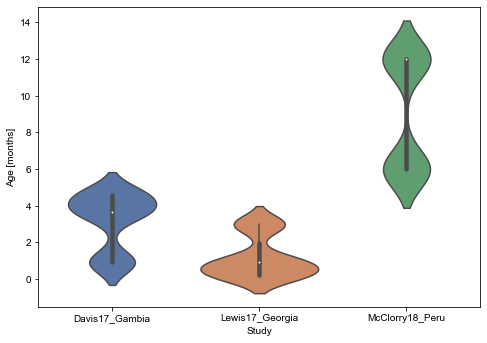

In [12]:
# plot continuous age distribution per Bioproject ID
fig, ax = plt.subplots(figsize=(7, 5), tight_layout=True)
sns.set(rc={"font.family": ["Arial"]}, style="white", font_scale=1.2)
sns.violinplot(ax=ax,
               data=df_meta,
               x="Study",
               y="AGE_month")
ax.set_xlabel("Study")
ax.set_ylabel("Age [months]")

fig.savefig(os.path.join(results_path, "draft_sfig_u1_age.eps"),
            bbox_inches='tight',
            dpi=300, format='eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


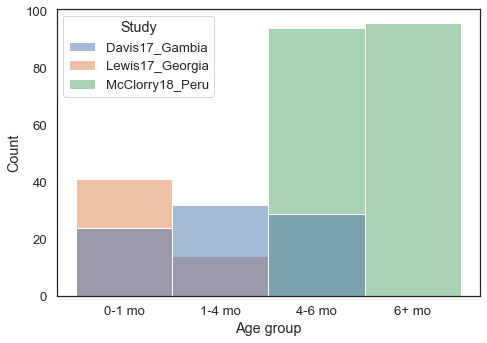

In [13]:
# plot binned age groups per Bioproject ID
fig, ax = plt.subplots(figsize=(7, 5), tight_layout=True)
sns.set(rc={"font.family": ["Arial"]}, style="white", font_scale=1.2)
sns.histplot(ax=ax,
             data=df_meta,
             x="AGE_month_group",
             hue="Study")
ax.set_xlabel("Age group")

fig.savefig(os.path.join(results_path, "draft_fig_u1A.eps"),
            bbox_inches='tight',
            dpi=300)


> The 3 studies focused on different age ranges of infants.

### Define classification target: `HEALTHY`

We are flagging infants as healthy or not based on the available metadata of all 3 studies.

In [14]:
# flagging healthy infants

bool_healthy = ((df_meta["Anemia [sample]"] != "anemic") &
                (~df_meta["Baby Status [sample]"].isin(["Borderline", "Abnormal"])) &
                (df_meta["Crp Status [sample]"] != "elevated") &
                ((df_meta["Parasites [sample]"] == "N") | (df_meta["Parasites [sample]"].isnull())) &
                (df_meta["Sick V Not Sick [sample]"] != "Sick") &
                (df_meta["Stunting [sample]"] != "Stunted") &
                (df_meta["Underweight [sample]"] != "Underweight") &
                (df_meta["Wasting [sample]"] != "Wasted")
                )
df_meta["HEALTHY"] = 0
df_meta.loc[bool_healthy, "HEALTHY"] = 1
df_meta["HEALTHY"].value_counts(dropna=False)


0    194
1    136
Name: HEALTHY, dtype: int64

Descriptive insight into fraction of healthy infants per Bioproject ID and its location:

In [15]:
# switch off inline mode to correctly display QIIME 2 visualizations
%matplotlib auto


Using matplotlib backend: <object object at 0x7f80a1f64a80>


In [16]:
# define healthy infant fraction per geolocation
df_meta["frac_HEALTHY"] = np.nan

for geo_loc in df_meta["Geo loc name [sample]"].unique():
    bool_geo_loc = (df_meta["Geo loc name [sample]"] == geo_loc)
    frac_healthy = df_meta.loc[bool_geo_loc, "HEALTHY"].mean()
    df_meta.loc[bool_geo_loc, "frac_HEALTHY"] = frac_healthy

assert(df_meta["frac_HEALTHY"].value_counts().values.all() ==
       df_meta["Geo loc name [sample]"].value_counts().values.all())

# plot map of healthy infant fraction per geolocation
ls_geo_cols = ['Latitude [sample]', 'Longitude [sample]', 'Elevation [sample]']
for col in ls_geo_cols:
    df_meta[col] = df_meta[col].astype(float)

# draw a map
map_frac_healthy, = coordinates.visualizers.draw_interactive_map(
    metadata=q2.Metadata(df_meta[ls_geo_cols + ['frac_HEALTHY']]),
    latitude='Latitude [sample]',
    longitude='Longitude [sample]',
    column='frac_HEALTHY',
    missing_data='ignore'
)
path2map = os.path.join(results_path, f'draft_fig_u1B_map')
map_frac_healthy.save(path2map)
map_frac_healthy


<visualization: Visualization uuid: afeed0b0-d194-4a90-b3e7-fd0be866ff28>

(If you are viewing this notebook on GitHub you can inspect the QIIME 2 visualization of the created map by viewing the file `u1-amplicon-results/draft_fig_u1B_map` in [the QIIME 2 Viewer](https://view.qiime2.org/).)

> The 3 geographically differently located studies differ in their fractions of healthy to unhealthy infants.

In [17]:
# adjust type of HEALTHY column from boolean to string (for Q2 compatibility below)
df_meta['HEALTHY'] = df_meta['HEALTHY'].astype(str)


## Train ML classifiers

Now we will train a RandomForest classifier with [q2-sample-classifier](https://github.com/qiime2/q2-sample-classifier) to predict infant's age and another one to predict if an infant is healthy or not given its microbiome.

! Beware, AUC values can deviate slightly (`+- 0.02`) when rerunning the above-mentioned denoising and rarefaction steps that include some randomness which can't be set with a defined seed yet.  

**! This prediction is merely a demonstration of what sort of analysis could be done with data fetched with *q2-fondue*. It is not to be reproduced when performing a proper meta-analysis as predicting these targets from the data at hand would require proper statistical adjustment for covariates.**

In [18]:
# display matplotlib inline again
%matplotlib inline


Predicting AGE_month_group:
Estimator Accuracy: 0.6333333333333334 ± 0.07228400267803978


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


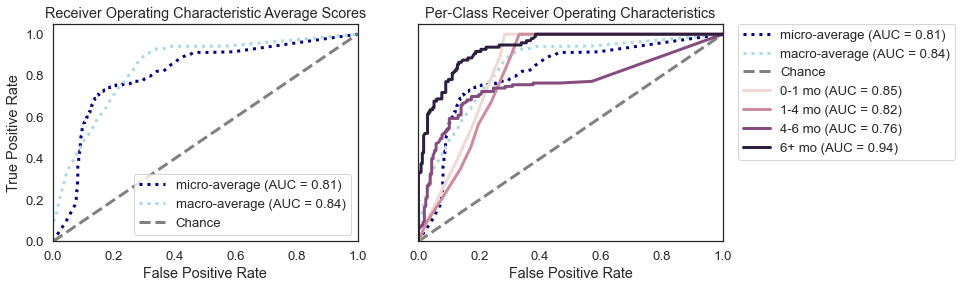

Predicting HEALTHY:
Estimator Accuracy: 0.5696969696969697 ± 0.026417569354791982


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


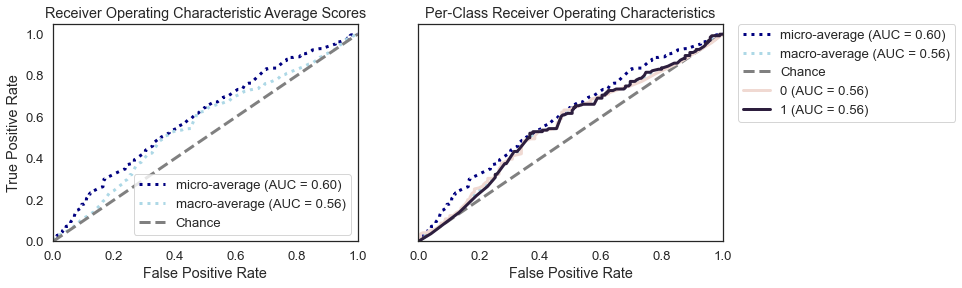

In [19]:
seed = 12
dic_file_flag = {"AGE_month_group": "C",
                 "HEALTHY": "D"}
for target in ['AGE_month_group', 'HEALTHY']:
    print(f'Predicting {target}:')
    res_combined = sc.actions.classify_samples_ncv(
        table=final_ft_table,
        metadata=q2.Metadata(df_meta).get_column(target),
        cv=10,
        random_state=seed,
        n_jobs=4,
        n_estimators=500,
        missing_samples='ignore')
    # save output artifact
    res_combined.probabilities.save(os.path.join(results_path, f'predprob_{target}.qza'))

    df_predprob = res_combined.probabilities.view(pd.DataFrame)
    df_predprob.sort_index(inplace=True)

    df_true = df_meta.loc[df_predprob.index, target].copy(deep=True)
    df_true.sort_index(inplace=True)

    # Plot ROC curve separately
    roc = _generate_roc_plots(df_true, df_predprob,
                              palette='sirocco')
    path4roc = os.path.join(
        results_path, f'draft_fig_u1{dic_file_flag[target]}.eps')
    roc.savefig(path4roc,
                bbox_inches='tight',
                dpi=300, format='eps')
    plt.show()


> It seems easier to predict an infant's age from its microbiome than its health status. **However, this result is not very reliable as the individual studies differ in many co-variates (e.g., age range, health status, geographical location) which we did not account for here. A proper meta-analysis would need to account for these covariates.**